<div>
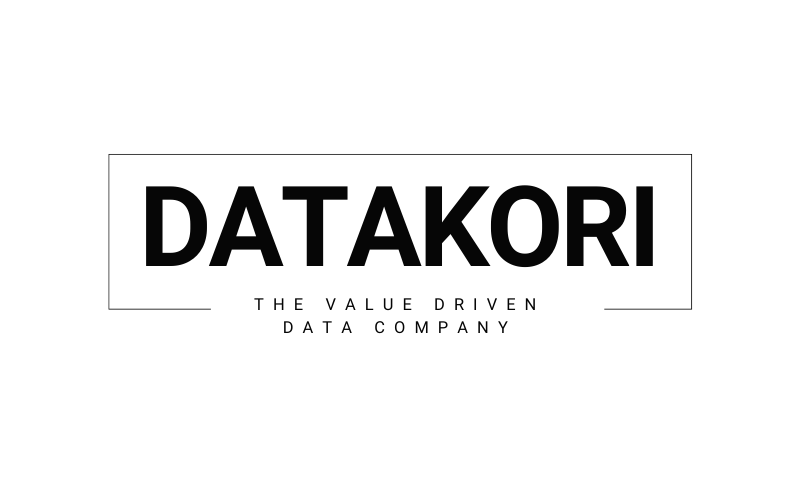
</div>

In [1]:
%load_ext jupyter_black

In [2]:
import sys
import pandas as pd
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType,
    StructField,
    IntegerType,
    StringType,
    FloatType,
)

## 1 - Spark session

In [4]:
# SparkSession est un point d'entrée pour Spark et depuis la version 2.0
# de spark, il est indispensable d'en créer une instance dès les premières lignes
# d'un programme spark pour pouvoir utiliser les RDD, DataFrame.


# un attribut de classe ayant un constructeur pour créer une instance de SparkSession.
# Permet de définir l'URL du noeud master  pour se connecter au cluster spark, such as "local"
# pour utiliser une version locale de spark, "local[4]" une version locale avec 3 cores,
# ou "spark://master:7077" pour s'exécuter sur un cluster Spark séparé.
# donne un nom à notre application afin que nous puissions la visualiser dans Spark UI
# Vérifie si une session spark globale existe déjà ou en crée une à défaut.

spark: SparkSession = (
    SparkSession.builder.master("local[*]").appName("small-exercices").getOrCreate()
)

## 2 - Create a dataframe for the study

In [5]:
data = [
    (1, "James", "Sales", 3000.0),
    (2, "Michael", "Sales", 4600.0),
    (3, "Robert", "Sales", 4100.0),
    (4, "Maria", "Finance", 3000.5),
    (5, "James", "Sales", 3000.5),
    (6, "Scott", "Finance", 3300.0),
    (7, "Jen", "Finance", 3900.0),
    (8, "Jena", "Finance", 3900.0),
    (9, "Jeff", "Marketing", 3000.0),
    (10, "Kumar", "Marketing", 2000.0),
    (11, "Kumar", "Marketing", 2000.0),
    (12, "Saif", "Sales", 4100.0),
]


schema = StructType(
    [
        StructField("id", IntegerType(), False),
        StructField("employee_name", StringType(), True),
        StructField("department", StringType(), True),
        StructField("salary", FloatType(), True),
    ]
)

df = spark.createDataFrame(data=data, schema=schema)
df.printSchema()

root
 |-- id: integer (nullable = false)
 |-- employee_name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: float (nullable = true)



In [6]:
df.show(truncate=False)

+---+-------------+----------+------+
|id |employee_name|department|salary|
+---+-------------+----------+------+
|1  |James        |Sales     |3000.0|
|2  |Michael      |Sales     |4600.0|
|3  |Robert       |Sales     |4100.0|
|4  |Maria        |Finance   |3000.5|
|5  |James        |Sales     |3000.5|
|6  |Scott        |Finance   |3300.0|
|7  |Jen          |Finance   |3900.0|
|8  |Jena         |Finance   |3900.0|
|9  |Jeff         |Marketing |3000.0|
|10 |Kumar        |Marketing |2000.0|
|11 |Kumar        |Marketing |2000.0|
|12 |Saif         |Sales     |4100.0|
+---+-------------+----------+------+



## 3 - Drop duplicated lines

In [10]:
# Create a temporay view that will last as long as the SparkSession
df.createOrReplaceTempView("people")

# In SQL
request = """
    SELECT employee_name, department, salary
    FROM people
    GROUP BY employee_name, department, salary
"""
spark.sql(request).show(truncate=False)

+-------------+----------+------+
|employee_name|department|salary|
+-------------+----------+------+
|James        |Sales     |3000.0|
|Michael      |Sales     |4600.0|
|Robert       |Sales     |4100.0|
|Maria        |Finance   |3000.5|
|Scott        |Finance   |3300.0|
|James        |Sales     |3000.5|
|Jen          |Finance   |3900.0|
|Jeff         |Marketing |3000.0|
|Jena         |Finance   |3900.0|
|Kumar        |Marketing |2000.0|
|Saif         |Sales     |4100.0|
+-------------+----------+------+



In [17]:
# In spark
df = df.drop_duplicates()
df.select("employee_name", "department", "salary").show(truncate=False)

+-------------+----------+------+
|employee_name|department|salary|
+-------------+----------+------+
|James        |Sales     |3000.0|
|Michael      |Sales     |4600.0|
|Robert       |Sales     |4100.0|
|Maria        |Finance   |3000.5|
|Scott        |Finance   |3300.0|
|James        |Sales     |3000.5|
|Jen          |Finance   |3900.0|
|Jena         |Finance   |3900.0|
|Jeff         |Marketing |3000.0|
|Kumar        |Marketing |2000.0|
|Saif         |Sales     |4100.0|
|Kumar        |Marketing |2000.0|
+-------------+----------+------+



## 4 - Cummulative sum 

In [15]:
windowSpec = Window.partitionBy("department").orderBy("salary")

df.select(
    "employee_name",
    "department",
    f.sum("salary").over(windowSpec.rowsBetween(-sys.maxsize, 0)).alias("sum"),
).show(truncate=False)

+-------------+----------+-------+
|employee_name|department|sum    |
+-------------+----------+-------+
|Maria        |Finance   |3000.5 |
|Scott        |Finance   |6300.5 |
|Jen          |Finance   |10200.5|
|Jena         |Finance   |14100.5|
|Kumar        |Marketing |2000.0 |
|Kumar        |Marketing |4000.0 |
|Jeff         |Marketing |7000.0 |
|James        |Sales     |3000.0 |
|James        |Sales     |6000.5 |
|Robert       |Sales     |10100.5|
|Saif         |Sales     |14200.5|
|Michael      |Sales     |18800.5|
+-------------+----------+-------+



In [13]:
request = """
    SELECT employee_name, department, salary,
        SUM(salary) OVER(PARTITION BY department ORDER BY salary ROWS BETWEEN unbounded preceding AND CURRENT ROW) AS sum  
    FROM people
    
    """

spark.sql(request).show()

+-------------+----------+------+-------+
|employee_name|department|salary|    sum|
+-------------+----------+------+-------+
|        Maria|   Finance|3000.5| 3000.5|
|        Scott|   Finance|3300.0| 6300.5|
|          Jen|   Finance|3900.0|10200.5|
|         Jena|   Finance|3900.0|14100.5|
|        Kumar| Marketing|2000.0| 2000.0|
|        Kumar| Marketing|2000.0| 4000.0|
|         Jeff| Marketing|3000.0| 7000.0|
|        James|     Sales|3000.0| 3000.0|
|        James|     Sales|3000.5| 6000.5|
|       Robert|     Sales|4100.0|10100.5|
|         Saif|     Sales|4100.0|14200.5|
|      Michael|     Sales|4600.0|18800.5|
+-------------+----------+------+-------+



## 5 - Row number 

In [14]:
# Return a sequential number starting at 1 within a window partion
# In spark
windowSpec = Window.partitionBy("department").orderBy(f.col("salary").desc())

df.withColumn("row_number", f.row_number().over(windowSpec)).show(truncate=False)

+---+-------------+----------+------+----------+
|id |employee_name|department|salary|row_number|
+---+-------------+----------+------+----------+
|7  |Jen          |Finance   |3900.0|1         |
|8  |Jena         |Finance   |3900.0|2         |
|6  |Scott        |Finance   |3300.0|3         |
|4  |Maria        |Finance   |3000.5|4         |
|9  |Jeff         |Marketing |3000.0|1         |
|10 |Kumar        |Marketing |2000.0|2         |
|11 |Kumar        |Marketing |2000.0|3         |
|2  |Michael      |Sales     |4600.0|1         |
|3  |Robert       |Sales     |4100.0|2         |
|12 |Saif         |Sales     |4100.0|3         |
|5  |James        |Sales     |3000.5|4         |
|1  |James        |Sales     |3000.0|5         |
+---+-------------+----------+------+----------+



In [18]:
# In SQL
request = """
    SELECT employee_name, department, 
        ROW_NUMBER() OVER(PARTITION BY department ORDER BY salary) AS rowNumber
    FROM people
"""
spark.sql(request).show()

+-------------+----------+---------+
|employee_name|department|rowNumber|
+-------------+----------+---------+
|        Maria|   Finance|        1|
|        Scott|   Finance|        2|
|          Jen|   Finance|        3|
|         Jena|   Finance|        4|
|        Kumar| Marketing|        1|
|        Kumar| Marketing|        2|
|         Jeff| Marketing|        3|
|        James|     Sales|        1|
|        James|     Sales|        2|
|       Robert|     Sales|        3|
|         Saif|     Sales|        4|
|      Michael|     Sales|        5|
+-------------+----------+---------+



## 6 - Rank

In [20]:
# The difference between rank and dense_rank is that dense_rank leaves 
# no gaps in ranking sequence when there are ties

# In spark
windowSpec = Window.partitionBy("department").orderBy("salary")

df.withColumn("ranks", f.rank().over(windowSpec)).show(truncate=False)

+---+-------------+----------+------+-----+
|id |employee_name|department|salary|ranks|
+---+-------------+----------+------+-----+
|4  |Maria        |Finance   |3000.5|1    |
|6  |Scott        |Finance   |3300.0|2    |
|7  |Jen          |Finance   |3900.0|3    |
|8  |Jena         |Finance   |3900.0|3    |
|10 |Kumar        |Marketing |2000.0|1    |
|11 |Kumar        |Marketing |2000.0|1    |
|9  |Jeff         |Marketing |3000.0|3    |
|1  |James        |Sales     |3000.0|1    |
|5  |James        |Sales     |3000.5|2    |
|3  |Robert       |Sales     |4100.0|3    |
|12 |Saif         |Sales     |4100.0|3    |
|2  |Michael      |Sales     |4600.0|5    |
+---+-------------+----------+------+-----+



In [21]:
# In SQL
request = """
    SELECT employee_name, department, salary,
        RANK() OVER(PARTITION BY department ORDER BY salary) AS ranks
    FROM people
"""

spark.sql(request).show()

+-------------+----------+------+-----+
|employee_name|department|salary|ranks|
+-------------+----------+------+-----+
|        Maria|   Finance|3000.5|    1|
|        Scott|   Finance|3300.0|    2|
|          Jen|   Finance|3900.0|    3|
|         Jena|   Finance|3900.0|    3|
|        Kumar| Marketing|2000.0|    1|
|        Kumar| Marketing|2000.0|    1|
|         Jeff| Marketing|3000.0|    3|
|        James|     Sales|3000.0|    1|
|        James|     Sales|3000.5|    2|
|       Robert|     Sales|4100.0|    3|
|         Saif|     Sales|4100.0|    3|
|      Michael|     Sales|4600.0|    5|
+-------------+----------+------+-----+



# 7 - Dense rank

In [22]:
# In spark
windowSpec = Window.partitionBy("department").orderBy("salary")

df.withColumn("dense_ranks", f.dense_rank().over(windowSpec)).show(truncate=False)

+---+-------------+----------+------+-----------+
|id |employee_name|department|salary|dense_ranks|
+---+-------------+----------+------+-----------+
|4  |Maria        |Finance   |3000.5|1          |
|6  |Scott        |Finance   |3300.0|2          |
|7  |Jen          |Finance   |3900.0|3          |
|8  |Jena         |Finance   |3900.0|3          |
|10 |Kumar        |Marketing |2000.0|1          |
|11 |Kumar        |Marketing |2000.0|1          |
|9  |Jeff         |Marketing |3000.0|2          |
|1  |James        |Sales     |3000.0|1          |
|5  |James        |Sales     |3000.5|2          |
|3  |Robert       |Sales     |4100.0|3          |
|12 |Saif         |Sales     |4100.0|3          |
|2  |Michael      |Sales     |4600.0|4          |
+---+-------------+----------+------+-----------+



In [23]:
# In SQL
request = """
    SELECT employee_name, department, salary, 
        DENSE_RANK() OVER(PARTITION BY department ORDER BY salary) AS dense_ranks
    FROM people
"""
spark.sql(request).show(truncate=False)

+-------------+----------+------+-----------+
|employee_name|department|salary|dense_ranks|
+-------------+----------+------+-----------+
|Maria        |Finance   |3000.5|1          |
|Scott        |Finance   |3300.0|2          |
|Jen          |Finance   |3900.0|3          |
|Jena         |Finance   |3900.0|3          |
|Kumar        |Marketing |2000.0|1          |
|Kumar        |Marketing |2000.0|1          |
|Jeff         |Marketing |3000.0|2          |
|James        |Sales     |3000.0|1          |
|James        |Sales     |3000.5|2          |
|Robert       |Sales     |4100.0|3          |
|Saif         |Sales     |4100.0|3          |
|Michael      |Sales     |4600.0|4          |
+-------------+----------+------+-----------+



# 8 - Percent rank

In [24]:
# returns the relative rank (i.e. percentile) of rows within a window partition
# In spark
df.withColumn("percent_ranks", f.percent_rank().over(windowSpec)).show(truncate=False)

+---+-------------+----------+------+------------------+
|id |employee_name|department|salary|percent_ranks     |
+---+-------------+----------+------+------------------+
|4  |Maria        |Finance   |3000.5|0.0               |
|6  |Scott        |Finance   |3300.0|0.3333333333333333|
|7  |Jen          |Finance   |3900.0|0.6666666666666666|
|8  |Jena         |Finance   |3900.0|0.6666666666666666|
|10 |Kumar        |Marketing |2000.0|0.0               |
|11 |Kumar        |Marketing |2000.0|0.0               |
|9  |Jeff         |Marketing |3000.0|1.0               |
|1  |James        |Sales     |3000.0|0.0               |
|5  |James        |Sales     |3000.5|0.25              |
|3  |Robert       |Sales     |4100.0|0.5               |
|12 |Saif         |Sales     |4100.0|0.5               |
|2  |Michael      |Sales     |4600.0|1.0               |
+---+-------------+----------+------+------------------+



In [25]:
# In SQL
request = """
    SELECT employee_name, department, salary, 
        PERCENT_RANK() OVER(PARTITION BY department ORDER BY salary) AS percent_ranks
    FROM people
"""
spark.sql(request).show(truncate=False)

+-------------+----------+------+------------------+
|employee_name|department|salary|percent_ranks     |
+-------------+----------+------+------------------+
|Maria        |Finance   |3000.5|0.0               |
|Scott        |Finance   |3300.0|0.3333333333333333|
|Jen          |Finance   |3900.0|0.6666666666666666|
|Jena         |Finance   |3900.0|0.6666666666666666|
|Kumar        |Marketing |2000.0|0.0               |
|Kumar        |Marketing |2000.0|0.0               |
|Jeff         |Marketing |3000.0|1.0               |
|James        |Sales     |3000.0|0.0               |
|James        |Sales     |3000.5|0.25              |
|Robert       |Sales     |4100.0|0.5               |
|Saif         |Sales     |4100.0|0.5               |
|Michael      |Sales     |4600.0|1.0               |
+-------------+----------+------+------------------+



# 9 - Ntile

In [35]:
# if n is 4, the first quarter of the rows will get value 1, the second quarter will get 2,
# the third quarter will get 3, and the last quarter will get 4.
# In spark
df.withColumn("ntiles", f.ntile(4).over(windowSpec)).show(truncate=False)

+---+-------------+----------+------+------+
|id |employee_name|department|salary|ntiles|
+---+-------------+----------+------+------+
|4  |Maria        |Finance   |3000.5|1     |
|6  |Scott        |Finance   |3300.0|2     |
|7  |Jen          |Finance   |3900.0|3     |
|8  |Jena         |Finance   |3900.0|4     |
|10 |Kumar        |Marketing |2000.0|1     |
|11 |Kumar        |Marketing |2000.0|2     |
|9  |Jeff         |Marketing |3000.0|3     |
|1  |James        |Sales     |3000.0|1     |
|5  |James        |Sales     |3000.5|1     |
|3  |Robert       |Sales     |4100.0|2     |
|12 |Saif         |Sales     |4100.0|3     |
|2  |Michael      |Sales     |4600.0|4     |
+---+-------------+----------+------+------+



In [36]:
# In SQL
request = """
    SELECT employee_name, department, salary, 
        NTILE(4) OVER(PARTITION BY department ORDER BY salary) AS ntiles
    FROM people
"""
spark.sql(request).show(truncate=False)

+-------------+----------+------+------+
|employee_name|department|salary|ntiles|
+-------------+----------+------+------+
|Maria        |Finance   |3000.5|1     |
|Scott        |Finance   |3300.0|2     |
|Jen          |Finance   |3900.0|3     |
|Jena         |Finance   |3900.0|4     |
|Kumar        |Marketing |2000.0|1     |
|Kumar        |Marketing |2000.0|2     |
|Jeff         |Marketing |3000.0|3     |
|James        |Sales     |3000.0|1     |
|James        |Sales     |3000.5|1     |
|Robert       |Sales     |4100.0|2     |
|Saif         |Sales     |4100.0|3     |
|Michael      |Sales     |4600.0|4     |
+-------------+----------+------+------+



## 10 - Lag

In [37]:
# Lag window function
df.withColumn("lag_salary", f.lag("salary", 1).over(windowSpec)).show()

+---+-------------+----------+------+----------+
| id|employee_name|department|salary|lag_salary|
+---+-------------+----------+------+----------+
|  4|        Maria|   Finance|3000.5|      null|
|  6|        Scott|   Finance|3300.0|    3000.5|
|  7|          Jen|   Finance|3900.0|    3300.0|
|  8|         Jena|   Finance|3900.0|    3900.0|
| 10|        Kumar| Marketing|2000.0|      null|
| 11|        Kumar| Marketing|2000.0|    2000.0|
|  9|         Jeff| Marketing|3000.0|    2000.0|
|  1|        James|     Sales|3000.0|      null|
|  5|        James|     Sales|3000.5|    3000.0|
|  3|       Robert|     Sales|4100.0|    3000.5|
| 12|         Saif|     Sales|4100.0|    4100.0|
|  2|      Michael|     Sales|4600.0|    4100.0|
+---+-------------+----------+------+----------+



In [38]:
# lag in sql
request = """
    SELECT employee_name, department, salary, 
        LAG(salary) OVER(PARTITION BY department ORDER BY salary) AS lags
    FROM people
"""
spark.sql(request).show(truncate=False)

+-------------+----------+------+------+
|employee_name|department|salary|lags  |
+-------------+----------+------+------+
|Maria        |Finance   |3000.5|null  |
|Scott        |Finance   |3300.0|3000.5|
|Jen          |Finance   |3900.0|3300.0|
|Jena         |Finance   |3900.0|3900.0|
|Kumar        |Marketing |2000.0|null  |
|Kumar        |Marketing |2000.0|2000.0|
|Jeff         |Marketing |3000.0|2000.0|
|James        |Sales     |3000.0|null  |
|James        |Sales     |3000.5|3000.0|
|Robert       |Sales     |4100.0|3000.5|
|Saif         |Sales     |4100.0|4100.0|
|Michael      |Sales     |4600.0|4100.0|
+-------------+----------+------+------+



# 11 - Lead

In [39]:
# Lead window function
df.withColumn("lead_salary", f.lead("salary", 1).over(windowSpec)).show(truncate=False)

+---+-------------+----------+------+-----------+
|id |employee_name|department|salary|lead_salary|
+---+-------------+----------+------+-----------+
|4  |Maria        |Finance   |3000.5|3300.0     |
|6  |Scott        |Finance   |3300.0|3900.0     |
|7  |Jen          |Finance   |3900.0|3900.0     |
|8  |Jena         |Finance   |3900.0|null       |
|10 |Kumar        |Marketing |2000.0|2000.0     |
|11 |Kumar        |Marketing |2000.0|3000.0     |
|9  |Jeff         |Marketing |3000.0|null       |
|1  |James        |Sales     |3000.0|3000.5     |
|5  |James        |Sales     |3000.5|4100.0     |
|3  |Robert       |Sales     |4100.0|4100.0     |
|12 |Saif         |Sales     |4100.0|4600.0     |
|2  |Michael      |Sales     |4600.0|null       |
+---+-------------+----------+------+-----------+



In [40]:
# Lead in sql
request = """
    SELECT employee_name, department, salary, 
        LEAD(salary) OVER(PARTITION BY department ORDER BY salary) AS leads
    FROM people
"""
spark.sql(request).show(truncate=False)

+-------------+----------+------+------+
|employee_name|department|salary|leads |
+-------------+----------+------+------+
|Maria        |Finance   |3000.5|3300.0|
|Scott        |Finance   |3300.0|3900.0|
|Jen          |Finance   |3900.0|3900.0|
|Jena         |Finance   |3900.0|null  |
|Kumar        |Marketing |2000.0|2000.0|
|Kumar        |Marketing |2000.0|3000.0|
|Jeff         |Marketing |3000.0|null  |
|James        |Sales     |3000.0|3000.5|
|James        |Sales     |3000.5|4100.0|
|Robert       |Sales     |4100.0|4100.0|
|Saif         |Sales     |4100.0|4600.0|
|Michael      |Sales     |4600.0|null  |
+-------------+----------+------+------+



## 12 - Bonus: replace a value by another one

In [42]:
# Replace Sales by Dir Com., Finance by Dir Fin., Marketing by Dir Mark. pyspark

df.withColumn(
    "new_department",
    f.when(f.col("department") == "Sales", "Dir. Com.")
    .when(f.col("department") == "Finance", "Dir. Fin.")
    .otherwise("Dir. Mark."),
).show(truncate=False)

+---+-------------+----------+------+--------------+
|id |employee_name|department|salary|new_department|
+---+-------------+----------+------+--------------+
|1  |James        |Sales     |3000.0|Dir. Com.     |
|2  |Michael      |Sales     |4600.0|Dir. Com.     |
|3  |Robert       |Sales     |4100.0|Dir. Com.     |
|4  |Maria        |Finance   |3000.5|Dir. Fin.     |
|6  |Scott        |Finance   |3300.0|Dir. Fin.     |
|5  |James        |Sales     |3000.5|Dir. Com.     |
|7  |Jen          |Finance   |3900.0|Dir. Fin.     |
|8  |Jena         |Finance   |3900.0|Dir. Fin.     |
|9  |Jeff         |Marketing |3000.0|Dir. Mark.    |
|10 |Kumar        |Marketing |2000.0|Dir. Mark.    |
|12 |Saif         |Sales     |4100.0|Dir. Com.     |
|11 |Kumar        |Marketing |2000.0|Dir. Mark.    |
+---+-------------+----------+------+--------------+



In [43]:
# Replace Sales by Dir Com., Finance by Dir Fin., Marketing by Dir Mark. SQL
request = """
    SELECT employee_name, department, salary,
        CASE
            WHEN department = 'Sales' THEN 'Dir. Com.' 
            WHEN department = 'Finance' THEN 'Dir. Fin.' 
            ELSE 'Dir. Mark.'
        END AS new_dept
    FROM people
"""
spark.sql(request).show(truncate=False)

+-------------+----------+------+----------+
|employee_name|department|salary|new_dept  |
+-------------+----------+------+----------+
|James        |Sales     |3000.0|Dir. Com. |
|Michael      |Sales     |4600.0|Dir. Com. |
|Robert       |Sales     |4100.0|Dir. Com. |
|Maria        |Finance   |3000.5|Dir. Fin. |
|James        |Sales     |3000.5|Dir. Com. |
|Scott        |Finance   |3300.0|Dir. Fin. |
|Jen          |Finance   |3900.0|Dir. Fin. |
|Jena         |Finance   |3900.0|Dir. Fin. |
|Jeff         |Marketing |3000.0|Dir. Mark.|
|Kumar        |Marketing |2000.0|Dir. Mark.|
|Kumar        |Marketing |2000.0|Dir. Mark.|
|Saif         |Sales     |4100.0|Dir. Com. |
+-------------+----------+------+----------+



## END